In [1]:
from model.speed_limit_detector import SpeedLimitDetector
from defense.hgd_trainer import get_HGD_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import cv2
from tqdm.auto import tqdm

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device
batch_size = 2

In [3]:
detector = SpeedLimitDetector(device)
hgd = get_HGD_model(device)

In [4]:
img_paths = glob('../model/datasets/tsinghua_gtsdb_speedlimit/test2017/*.jpg')[:]
preprocessed_imgs = []
for img_path in img_paths:
    img = cv2.imread(img_path)
    img = detector.preprocess(img)
    preprocessed_imgs.append(img)

In [5]:
print(len(preprocessed_imgs))

782


In [6]:
def plot_images(images, title="",transpose=False, rgb=True):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    fig.suptitle(title, fontsize=16)
    axs = axs.flatten()
    for i, img in enumerate(images):
        img = img.transpose((1, 2, 0)) if transpose else img
        img = np.asarray(img, dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if rgb else img
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

In [7]:
@torch.no_grad()
def denoise(images):
    images_tensor = torch.from_numpy(np.asarray(images)).to(device)
    hgd.eval()
    noise = hgd(images_tensor)
    denoised = images_tensor - noise
    return denoised.cpu().numpy(), noise.cpu().numpy()

In [8]:
@torch.no_grad()
def detect_sign(images):
    images_tensor = torch.from_numpy(np.asarray(images)).to(device)
    outputs = detector.get_model_output(images_tensor)
    decoded_outputs = []
    for output in outputs:
        decoded_outputs.append(detector.decode_model_output(output))
    return decoded_outputs

In [9]:
@torch.no_grad()
def get_iou(box1, box2):

    # xmin, ymin, xmax, ymax = box
    
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2
    
    yi1 = max(y11, y12)
    xi1 = max(x11, x12)
    yi2 = min(y21, y22)
    xi2 = min(x21, x22)
    inter_area = max(((xi2 - xi1) * (yi2 - yi1)), 0)
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (x21 - x11) * (y21 - y11)
    box2_area = (x22 - x12) * (y22 - y12)
    union_area = box1_area + box2_area - inter_area
    # compute the IoU
    iou = inter_area / union_area
    return iou

In [10]:
@torch.no_grad()
def calculate_metric(results_to_be_measured,results_name:str):
    results = []
    conf_threshold = 0.8
    IOU_threshold = 0.7
    avg_conf = 0
    conf_count = 0
    for i, result in enumerate(results_to_be_measured):
        if result is not None:
            (clss, confs, bbs) = result[0],result[1],result[2]
        elif benign_images_results[i] is None:
            results.append(1)
            continue
        else:
            results.append(0)
            continue
        for cls, conf, bb in zip(clss,confs,bbs):
            if conf < conf_threshold:
                continue
            
            avg_conf += conf
            conf_count += 1
            
            if benign_images_results[i] is None:
                results.append(0)
                continue
            
            if benign_images_results[i][2].shape[0] > 1:

                max_iou = 0

                for bb_idx, bb_benign in enumerate(benign_images_results[i][2]):

                    IOU = get_iou(bb,bb_benign)
                    if IOU > max_iou:
                        max_iou = IOU
                        idx = bb_idx

            else:
                max_iou = get_iou(bb,benign_images_results[i][2][0])
                idx = 0

            if max_iou < IOU_threshold:
                results.append(0)
                continue
                
            if cls == benign_images_results[i][0][idx]:
                results.append(1)
            else:
                results.append(0)


    print(f"{np.asarray(results).mean():.4f} of bounding boxes in {results_name} are correct\nAverage confidence of non-rejected bounding boxes is {avg_conf/conf_count}")

## Setup all attack methods

In [11]:
from attack.fgsm import FGSM
from attack.iterative_fgsm import ItFGSM
from attack.pgd import PGD
from model.custom_yolo import yolox_loss, yolox_target_generator

fgsm = FGSM()
fgsm.model = detector.model
fgsm.target_generator = yolox_target_generator
fgsm.loss = yolox_loss

it_fgsm = ItFGSM()
it_fgsm.model = detector.model
it_fgsm.target_generator = yolox_target_generator
it_fgsm.loss = yolox_loss

pgd = PGD()
pgd.model = detector.model
pgd.target_generator = yolox_target_generator
pgd.loss = yolox_loss

## Generate Attacked Images
### Run one attack at a time to reduce memory usage

In [12]:
fgsm_attacked_images = []
it_fgsm_attacked_images = []
pgd_attacked_images = []

for img in tqdm(preprocessed_imgs):
    img = torch.from_numpy(img[None, :, :, :]).to(device)
#     fgsm_attacked = fgsm.generate_attack(img, return_numpy=True)[0]
    it_fgsm_attacked = it_fgsm.generate_attack(img, return_numpy=True)[0]
#     pgd_attacked = pgd.generate_attack(img, return_numpy=True)[0]

#     fgsm_attacked_images.append(fgsm_attacked)
    it_fgsm_attacked_images.append(it_fgsm_attacked)
    #pgd_attacked_images.append(pgd_attacked)

  0%|          | 0/782 [00:00<?, ?it/s]

## Get Benign Image Results and Denoise Benign Images

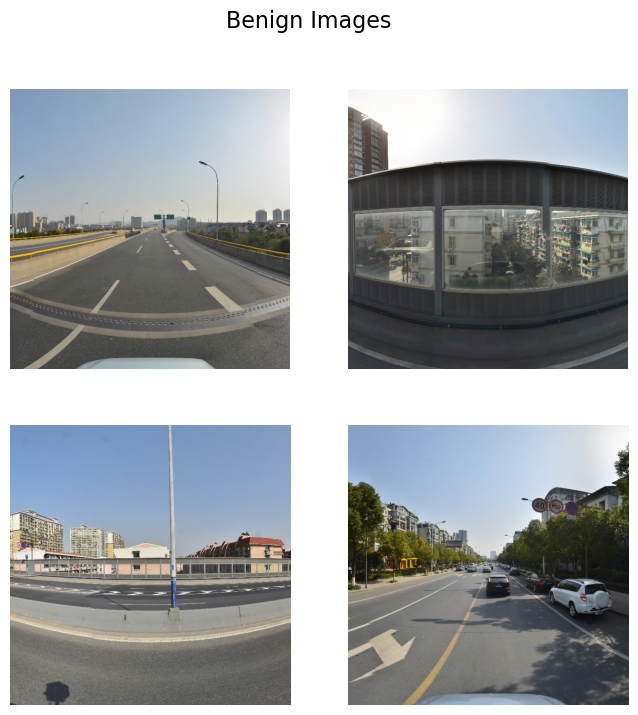

  0%|          | 0/391 [00:00<?, ?it/s]

C:\Users\PC\anaconda3\envs\carlaEnv\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


  0%|          | 0/782 [00:00<?, ?it/s]

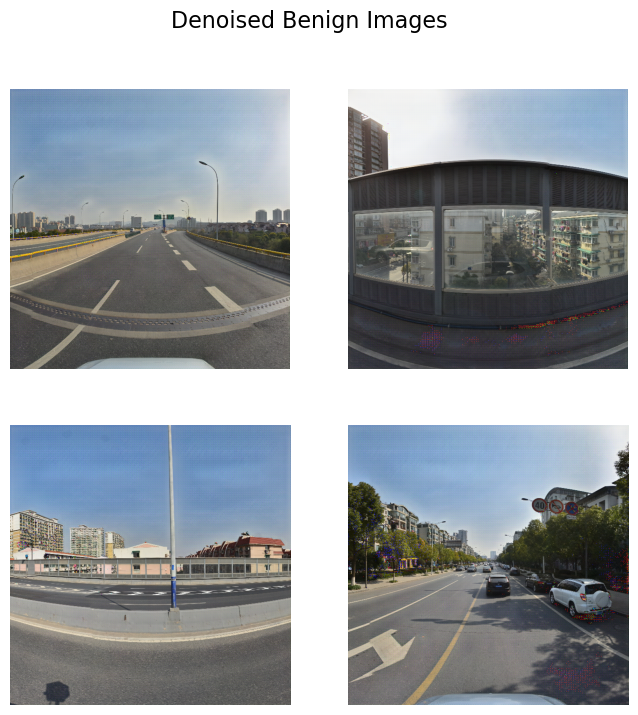

In [13]:
with torch.no_grad():
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    fig.suptitle("Benign Images", fontsize=16)
    axs = axs.flatten()
    for i, img in enumerate(preprocessed_imgs[:4]):
        img = img.transpose((1, 2, 0))
        img = np.asarray(img, dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()
    benign_images_results = []
    
    for start_idx in tqdm(range(0,len(preprocessed_imgs),batch_size)):
        benign_images_results.append(detect_sign(preprocessed_imgs[start_idx:start_idx+batch_size]))
    
    benign_images_results = np.array(benign_images_results)
    benign_images_results = benign_images_results.reshape(benign_images_results.shape[0]*benign_images_results.shape[1])
    
    denoised_benign_images = []
    for img in tqdm(preprocessed_imgs):
        denoised_benign_images.append(denoise([img])[0])


    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    fig.suptitle("Denoised Benign Images", fontsize=16)
    axs = axs.flatten()
    for i, img in enumerate(denoised_benign_images[:4]):
        img = img[0].transpose((1, 2, 0))
        img = np.asarray(img, dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()



    # for img in denoised_benign_images:
    #     print(detect_sign(img))


In [ ]:
# plot_images(fgsm_attacked_images[:4], transpose=True, title="FGSM attacked Images")
# detect_sign(fgsm_attacked_images[:4])

## Denoise FGSM Images and Get Model Results

  0%|          | 0/391 [00:00<?, ?it/s]

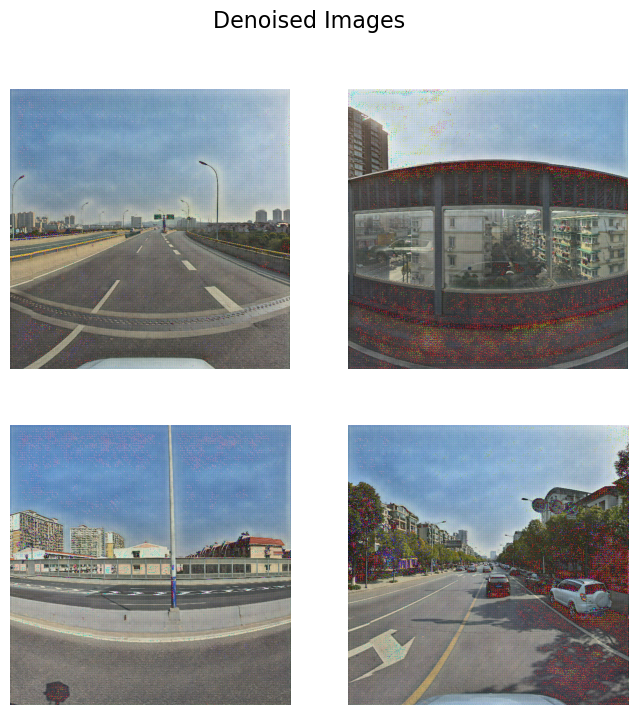

  0%|          | 0/391 [00:00<?, ?it/s]

C:\Users\PC\anaconda3\envs\carlaEnv\lib\site-packages\ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


  0%|          | 0/782 [00:00<?, ?it/s]

In [14]:
denoised_fgsm = []
noise_fgsm = []
with torch.no_grad():
    for start_idx in tqdm(range(0,len(fgsm_attacked_images),batch_size)):
        results_tuple = denoise(fgsm_attacked_images[start_idx:start_idx+batch_size])
        denoised_fgsm.append(results_tuple[0])
        noise_fgsm.append(results_tuple[1]) 
    
    denoised_fgsm = np.array(denoised_fgsm)
    denoised_fgsm = denoised_fgsm.reshape(denoised_fgsm.shape[0]*denoised_fgsm.shape[1],denoised_fgsm.shape[2],denoised_fgsm.shape[3],denoised_fgsm.shape[4])

    noise_fgsm = np.array(noise_fgsm)
    noise_fgsm = noise_fgsm.reshape(noise_fgsm.shape[0]*noise_fgsm.shape[1],noise_fgsm.shape[2],noise_fgsm.shape[3],noise_fgsm.shape[4])
    

    
    plot_images(noise_fgsm[:4], title="Noise",transpose=True, rgb = True)
    plot_images(denoised_fgsm[:4], title="Denoised Images",transpose=True, rgb=True)
    
    denoised_fgsm_results = []
    for start_idx in tqdm(range(0,len(denoised_fgsm),batch_size)):
        denoised_fgsm_results.append(detect_sign(denoised_fgsm[start_idx:start_idx+batch_size]))
    
    denoised_fgsm_results = np.array(denoised_fgsm_results)
    denoised_fgsm_results = denoised_fgsm_results.reshape(denoised_fgsm_results.shape[0]*denoised_fgsm_results.shape[1])
    for i,element in enumerate(tqdm(denoised_fgsm_results)):
        if element is None:
            continue
        denoised_fgsm_results[i] = list(element)
        

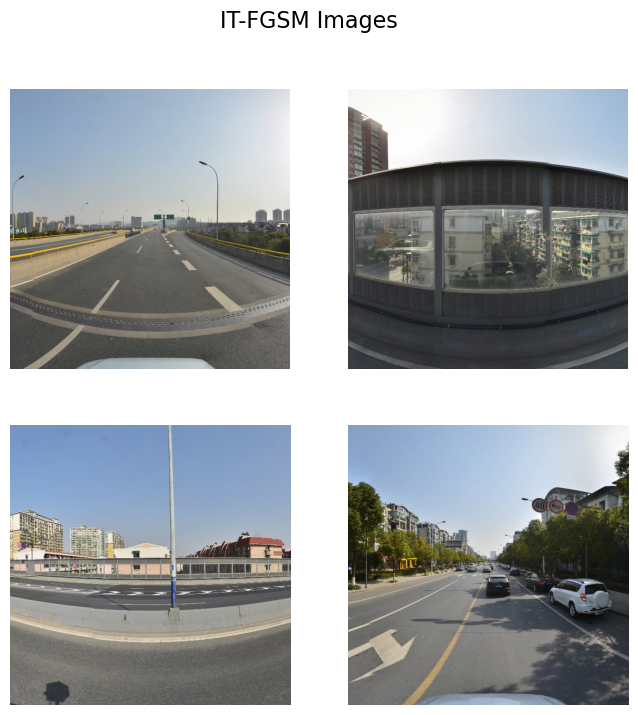

In [19]:
plot_images(it_fgsm_attacked_images[:4], transpose=True,title = "IT-FGSM Images")

## Denoise IT-FGSM Images and Get Model Results

  0%|          | 0/391 [00:00<?, ?it/s]

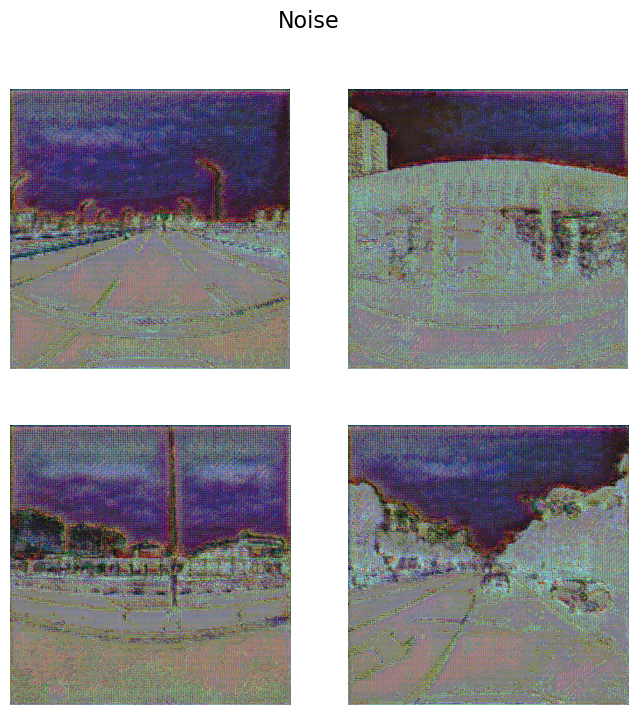

  0%|          | 0/391 [00:00<?, ?it/s]

C:\Users\PC\anaconda3\envs\carlaEnv\lib\site-packages\ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


  0%|          | 0/782 [00:00<?, ?it/s]

In [15]:
denoised_it_fgsm = []
noise_it_fgsm = []
with torch.no_grad():
    for start_idx in tqdm(range(0,len(it_fgsm_attacked_images),batch_size)):
        results_tuple = denoise(it_fgsm_attacked_images[start_idx:start_idx+batch_size])
        denoised_it_fgsm.append(results_tuple[0])
        noise_it_fgsm.append(results_tuple[1]) 
    
    denoised_it_fgsm = np.array(denoised_it_fgsm)
    denoised_it_fgsm = denoised_it_fgsm.reshape(denoised_it_fgsm.shape[0]*denoised_it_fgsm.shape[1],denoised_it_fgsm.shape[2],denoised_it_fgsm.shape[3],denoised_it_fgsm.shape[4])

    noise_it_fgsm = np.array(noise_it_fgsm)
    noise_it_fgsm = noise_it_fgsm.reshape(noise_it_fgsm.shape[0]*noise_it_fgsm.shape[1],noise_it_fgsm.shape[2],noise_it_fgsm.shape[3],noise_it_fgsm.shape[4])
    

    
    plot_images(noise_it_fgsm[:4], title="Noise",transpose=True, rgb = True)
    plot_images(denoised_it_fgsm[:4], title="Denoised Images",transpose=True, rgb=True)
    
    denoised_it_fgsm_results = []
    for start_idx in tqdm(range(0,len(denoised_it_fgsm),batch_size)):
        denoised_it_fgsm_results.append(detect_sign(denoised_it_fgsm[start_idx:start_idx+batch_size]))
    
    denoised_it_fgsm_results = np.array(denoised_it_fgsm_results)
    denoised_it_fgsm_results = denoised_it_fgsm_results.reshape(denoised_it_fgsm_results.shape[0]*denoised_it_fgsm_results.shape[1])
    for i,element in enumerate(tqdm(denoised_it_fgsm_results)):
        if element is None:
            continue
        denoised_it_fgsm_results[i] = list(element)

In [ ]:
denoised, noise = denoise(it_fgsm_attacked_images)
plot_images(noise[:4], title="Noise",transpose=True)
plot_images(denoised[:4], title="Denoised Images",transpose=True)
denoised_it_fgsm_results = detect_sign(denoised)

## Get Model Results for Denoised Benign Images

In [25]:
with torch.no_grad():
    denoised_benign_images = np.array(denoised_benign_images)
    denoised_benign_images = denoised_benign_images.reshape(denoised_benign_images.shape[0]*denoised_benign_images.shape[1],denoised_benign_images.shape[2],denoised_benign_images.shape[3],denoised_benign_images.shape[4])
    denoised_benign_results = []
    for start_idx in tqdm(range(0,len(denoised_benign_images),batch_size)):
        denoised_benign_results.append(detect_sign(denoised_benign_images[start_idx:start_idx+batch_size]))
    
    denoised_benign_results = np.array(denoised_benign_results)
    denoised_benign_results = denoised_benign_results.reshape(denoised_benign_results.shape[0]*denoised_benign_results.shape[1])
    for i,element in enumerate(tqdm(denoised_benign_results)):
        if element is None:
            continue
        denoised_benign_results[i] = list(element)

  0%|          | 0/391 [00:00<?, ?it/s]

C:\Users\PC\anaconda3\envs\carlaEnv\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


  0%|          | 0/782 [00:00<?, ?it/s]

## Get Model Results for FGSM Images

In [17]:
with torch.no_grad():    
    fgsm_results = []
    for start_idx in tqdm(range(0,len(fgsm_attacked_images),batch_size)):
        fgsm_results.append(detect_sign(fgsm_attacked_images[start_idx:start_idx+batch_size]))
    
    fgsm_results = np.array(fgsm_results)
    fgsm_results = fgsm_results.reshape(fgsm_results.shape[0]*fgsm_results.shape[1],fgsm_results.shape[2])

    for i,element in enumerate(tqdm(fgsm_results)):
        if element is None:
            continue
        fgsm_results[i] = list(element)

  0%|          | 0/391 [00:00<?, ?it/s]

C:\Users\PC\anaconda3\envs\carlaEnv\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


  0%|          | 0/782 [00:00<?, ?it/s]

## Get Model Results for IT-FGSM Images

In [14]:
with torch.no_grad():    
    it_fgsm_results = []
    for start_idx in tqdm(range(0,len(it_fgsm_attacked_images),batch_size)):
        it_fgsm_results.append(detect_sign(it_fgsm_attacked_images[start_idx:start_idx+batch_size]))
    
    it_fgsm_results = np.array(it_fgsm_results)
    it_fgsm_results = it_fgsm_results.reshape(it_fgsm_results.shape[0]*it_fgsm_results.shape[1],it_fgsm_results.shape[2])

    for i,element in enumerate(tqdm(it_fgsm_results)):
        if element is None:
            continue
        it_fgsm_results[i] = list(element)

  0%|          | 0/391 [00:00<?, ?it/s]

C:\Users\PC\anaconda3\envs\carlaEnv\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


  0%|          | 0/782 [00:00<?, ?it/s]

## Metric Results

In [26]:
calculate_metric(denoised_benign_results, "Denoised Benign")

0.9928 of bounding boxes in Denoised Benign are correct
Average confidence of non-rejected bounding boxes is 0.8764400858741375


In [18]:
calculate_metric(fgsm_results, "FGSM Images")

0.6065 of bounding boxes in FGSM Images are correct
Average confidence of non-rejected bounding boxes is 0.8531521495293688


In [17]:
calculate_metric(denoised_fgsm_results, "denoised FGSM")

0.8147 of bounding boxes in denoised FGSM are correct
Average confidence of non-rejected bounding boxes is 0.8663147422832205


In [15]:
calculate_metric(it_fgsm_results,"IT-FGSM Results")

0.0034 of bounding boxes in IT-FGSM Results are correct
Average confidence of non-rejected bounding boxes is 0.8726816055745289


In [16]:
calculate_metric(denoised_it_fgsm_results, "denoised IT FGSM")

0.6752 of bounding boxes in denoised IT FGSM are correct
Average confidence of non-rejected bounding boxes is 0.862736709256029
